In [ ]:
#basic libraries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Helper functions
import numpy as np

def plot_curve1(pts, x_label, y_label, title):
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  index = np.arange(1, len(pts)+1, 1)
  plt.plot(index, pts, '-b')
  
  plt.show()

def plot_curve2(pts1, pts2, x_label, y_label, title, legend):
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  index = np.arange(1, len(pts1)+1, 1)
  plt.plot(index, pts1, '-b', label=legend[0])
  plt.plot(index, pts2, '-r', label=legend[1])

  plt.legend()
  plt.show()
  
# Enter your code here
def stepsize_schedule(eta, eta0, eta1, lr_min):
    return max(lr_min, eta0 / (eta + eta1))

def initialize_Weights(nrows, ncols):
  np.random.seed(42)
  W = np.random.normal(0, 1, size=(nrows, ncols))*0.05
  b = np.zeros((nrows, 1))
  return W, b


In [ ]:
####################################Softmax regression##########################
#implementing the Softmax layer (can be used both in a regression and NN sense)
def Softmax_layer(X, W_t, b_t):
  #as mentioned W is cxn, and X is nxm and b is cx1
  Z = W_t.dot(X) + b_t
  #exponentiating and normalizing
  t = np.exp(Z)
  A = t/(np.sum(t, axis=0).reshape(1, Z.shape[1]))
  return Z, A

def cost_Softmax(X, Y, W_t, b_t, bs, lambda_reg):
  #Frobenius norm is a greater than the L2 norm and is computationally less expensive (no eigenvalue calculation is required)
  _, A = Softmax_layer(X, W_t, b_t)
  cost_batch = -1*np.sum(Y*np.log(A)) +  0.5*lambda_reg*np.sum(W_t*W_t)
  cost_avg = cost_batch/bs 
  return cost_avg

def grad_Softmax(X, Y, W_t, b_t, bs, lambda_reg):
  #as mentioned W is cxn, and X is nxm and b is cx1
  Z = W_t.dot(X) + b_t
  #exponentiating and normalizing
  t = np.exp(Z)
  A = t/(np.sum(t, axis=0).reshape(1, Z.shape[1]))
  #derivative of Frobenius norm is the matrix itself
  dW_t =  (A - Y).dot(X.T) + lambda_reg*W_t
  dW_t = dW_t/bs
  db_t = np.sum((A - Y), axis=1).reshape(Y.shape[0], 1)
  db_t = db_t/bs
  return dW_t, db_t

def accuracy(X, Y, W, b):
  _, A = Softmax_layer(X, W, b)
  Y_hat = np.argmax(A, axis=0) 
  #number of 1's selected: i.e., number of correct predictions
  n_correct = np.sum(Y[Y_hat, np.arange(0, X.shape[1])])
  acc = n_correct/X.shape[1]
  return acc
#############################Deep Neural network################################
def sigmoid(z):
  return 1/(1+np.exp(-1*z)+1E-9)

def d_sigmoid(z):
  return (1-sigmoid(z))*sigmoid(z)

#defined for a single hidden layer and will inturn call softmax regression
#Note this is not a general code (that is it will only work for a single hidden layer)

def forward_prop(X, W_1t, b_1t, W_2t, b_2t):
  #output of the first layer
  Z_1 = W_1t.dot(X) + b_1t
  #the paper used sigmoid/ otherwise I would have used RELU
  A_1 = sigmoid(Z_1)
  #now call the softmax layer
  Z_2, A_2 = Softmax_layer(A_1, W_2t, b_2t)
  #stores the value
  cache = {"Z_1": Z_1,
           "A_1": A_1,
           "Z_2": Z_2,
           "A_2": A_2}
  return cache

def cost_NN(X, Y, W_1t, b_1t, W_2t, b_2t, lambda_reg, bs):
  cache = forward_prop(X, W_1t, b_1t, W_2t, b_2t)
  cost_batch = -1*np.sum(Y*np.log(cache["A_2"])) +  0.5*lambda_reg*np.sum(W_1t*W_1t) + 0.5*lambda_reg*np.sum(W_2t*W_2t) 
  cost_avg = cost_batch/bs  
  return cost_avg

def back_prop(X, Y, W_1t, b_1t, W_2t, b_2t, bs, lambda_reg):
  #cache contains all the outputs
  cache = forward_prop(X, W_1t, b_1t, W_2t, b_2t)
  dz_2 = cache["A_2"] - Y
  #second layer backpropagation
  dW_2 = dz_2.dot(cache["A_1"].T) + lambda_reg*W_2t
  dW_2 = dW_2/bs
  db_2 = np.sum(dz_2, axis=1, keepdims=True)/bs
  
  #first layer backpropagation
  dz_1 = (W_2t.T.dot(dz_2))*d_sigmoid(cache["Z_1"])
  dW_1 = dz_1.dot(X.T) + lambda_reg*W_1t
  dW_1 = dW_1/bs
  db_1 = np.sum(dz_1, axis=1, keepdims=True)/bs

  gradients_t = {"dW_2t": dW_2,
                "db_2t": db_2,
                "dW_1t": dW_1,
                "db_1t": db_1}

  return gradients_t

def accuracy_NN(X, Y, W_1, b_1, W_2, b_2):
  cache = forward_prop(X, W_1, b_1, W_2, b_2)
  Y_hat = np.argmax(cache["A_2"], axis=0) 
  #number of 1's selected: i.e., number of correct predictions
  n_correct = np.sum(Y[Y_hat, np.arange(0, X.shape[1])])
  acc = n_correct/X.shape[1]
  return acc

In [ ]:
def GradDescent_softmax(X, Y, X_val, Y_val, lambda_reg, beta_momentum, n_iter, lr):
  #weight W will be cxn dimensional
  W_t, b_t = initialize_Weights(Y.shape[0], X.shape[0])
  cost = []
  train_acc = []
  val_acc = []
  
  W_t_1 = W_t
  b_t_1 = b_t
  
  np.random.seed(10)
  for i in range(n_iter):
    if i>0 and i%500==0:
      print("Cost after "+str(i)+" iterations: "+str(cost_Softmax(X, Y, W_t, b_t, X.shape[1], lambda_reg)))
    if i==50 or i%299 == 0:
      cost.append(cost_Softmax(X, Y, W_t, b_t, X.shape[1], lambda_reg))
      train_acc.append(accuracy(X, Y, W_t, b_t))
      val_acc.append(accuracy(X_val, Y_val, W_t, b_t))
    
    
    dW_t, db_t = grad_Softmax(X, Y, W_t, b_t, X.shape[1], lambda_reg)
    #store the previous iterate
    tempW = W_t
    tempb = b_t

    W_t = W_t - lr*dW_t + beta_momentum*(W_t - W_t_1) 
    b_t = b_t - lr*db_t + beta_momentum*(b_t - b_t_1)

    W_t_1 = tempW
    b_t_1 = tempb

  plot_curve1(cost, "iterations/50 (plotted per 50 iterations)", "cost", "Trend in the cost function in Full grad descent, for Softmax Regression") 
  
  if beta_momentum == 0:
    print("Final cost using Gradient descent: "+str(cost[-1])+", train set accuracy = "+str(train_acc[-1])+", validation set accuracy = "+str(val_acc[-1]))
    plot_curve1(val_acc, "iterations/50 (plotted per 50 iterations)", " validation accuracy", "Learing curve for gradient descent", ["Train Set accuracy", "Cross-Validation Set Accuracy"])
  else:
    print("Final cost using gradient descent (with momentum coeff $beta$ = "+ str(beta_momentum)+"): "+str(cost[-1])+", train set accuracy = "+str(train_acc[-1])+", validation set accuracy = "+str(val_acc[-1])) 
    plot_curve2(train_acc, val_acc, "iterations/512 (plotted per 512 iterations: same convention as SVRG)", "accuracy", "Learing curve for gradient descent (with momentum coeff $beta$ = "+ str(beta_momentum)+")", ["Train Set accuracy", "Cross-Validation Set Accuracy"])
  
  return  W_t, b_t 

###########################This is the softmax regression#######################
##########################Stochastic Gradient Descent###########################
def Stochastic_GradDescent(X, Y, X_val, Y_val, lambda_reg, beta_momentum, eta0, eta1, epochs, lr_min, f_opt):
  #weight W will be cxn dimensional
  W_t, b_t = initialize_Weights(Y.shape[0], X.shape[0])
  cost = []
  train_acc = []
  val_acc = []
  
  W_t_1 = W_t
  b_t_1 = b_t
  
  np.random.seed(10)
  for i in range(int(epochs*X.shape[1])):
    if i>0 and i%20000==0:
      print("Cost after "+str(i)+" iterations: "+str(cost_Softmax(X, Y, W_t, b_t, X.shape[1], lambda_reg) - f_opt))
    if i%512 == 0:
      cost.append(cost_Softmax(X, Y, W_t, b_t, X.shape[1], lambda_reg)- f_opt)
      #train_acc.append(accuracy(X, Y, W_t, b_t))
      val_acc.append(accuracy(X_val, Y_val, W_t, b_t))
    lr = stepsize_schedule(i, eta0, eta1, lr_min)

    #choose a random A, y (between 0 and m)
    randselect = np.random.randint(0, X.shape[1], size=1)
    X_random = X[:, randselect]
    Y_random = Y[:, randselect]
    
    dW_t, db_t = grad_Softmax(X_random, Y_random, W_t, b_t, 1, lambda_reg)
    #store the previous iterate
    tempW = W_t
    tempb = b_t

    W_t = W_t - lr*dW_t + beta_momentum*(W_t - W_t_1) 
    b_t = b_t - lr*db_t + beta_momentum*(b_t - b_t_1)

    W_t_1 = tempW
    b_t_1 = tempb

  plot_curve1(cost, "iterations/512 (plotted per 512 iterations)", "Suboptimality gap", "Trend in the suboptimality gap of function, for Softmax Regression (SGD)") 
  print("Final cost using Gradient descent: "+str(cost[-1])+"validation set accuracy = "+str(val_acc[-1]))
  
  plot_curve1(val_acc, "iterations/512 (plotted per 512 iterations)", " validation accuracy", "Learing curve for SGD")
  
  return  W_t, b_t, cost 

#############################SVRG###############################################
def SVRG(X, Y, X_val, Y_val, lambda_reg, lr, epochs, T, f_opt):
  #weight W will be cxn dimensional
  W_t, b_t = initialize_Weights(Y.shape[0], X.shape[0])
  cost = []
  train_acc = []
  val_acc = []
  
  np.random.seed(10)
  for i in range(epochs):
    if i>0 and i%40==0:
      print("Cost after "+str(i)+" epochs: "+str(cost_Softmax(X, Y, W_t, b_t, X.shape[1], lambda_reg)-f_opt))
    
    cost.append(cost_Softmax(X, Y, W_t, b_t, X.shape[1], lambda_reg)-f_opt)
    #train_acc.append(accuracy(X, Y, W_t, b_t))
    val_acc.append(accuracy(X_val, Y_val, W_t, b_t))
    
    #will store the sum
    W_inner = W_t
    b_inner = b_t
    W_inner_sum = np.zeros(W_t.shape)
    b_inner_sum = np.zeros(b_t.shape)
    #global snapshot of real gradient
    dW_t, db_t = grad_Softmax(X, Y, W_t, b_t, X.shape[1], lambda_reg)
    
    for j in range(T):
      #choose a random A, y (between 0 and m)
      randselect = np.random.randint(0, X.shape[1], size=1)
      X_random = X[:, randselect]
      Y_random = Y[:, randselect]
      
      dW_old, db_old = grad_Softmax(X_random, Y_random, W_t, b_t, 1, lambda_reg)
      dW_new, db_new = grad_Softmax(X_random, Y_random, W_inner, b_inner, 1, lambda_reg)

      W_inner = W_inner - lr*(dW_new - (dW_old - dW_t))
      b_inner = b_inner - lr*(db_new - (db_old - db_t))

      #stores the weight update sums
      W_inner_sum = W_inner_sum + W_inner
      b_inner_sum = b_inner_sum + b_inner

    #storing the average 
    W_t = (W_inner_sum)/T  
    b_t = (b_inner_sum)/T 

  plot_curve1(cost, "iterations/512 (plotted per 512 iterations)", "Suboptimality gap", "Trend in the suboptimality gap of function, for Softmax Regression (SVRG)") 
  print("Final cost using Gradient descent: "+str(cost[-1])+"validation set accuracy = "+str(val_acc[-1]))
  
  plot_curve1(val_acc, "iterations/512 (plotted per 512 iterations)", " validation accuracy", "Learing curve for SGD")

  return  W_t, b_t, cost 

def SDCA(X, Y, X_val, Y_val, lambda_reg, lr, epochs, T, f_opt):
  W_t, b_t = initialize_Weights(Y.shape[0], X.shape[0])
  cost = []
  train_acc = []
  val_acc = []

  np.random.seed(10)
  #Enter SDCA
  
  grad_Softmax(X, Y, W_t, b_t, X.shape[1], lambda_reg)
  
  
  plot_curve1(cost, "iterations/512 (plotted per 512 iterations)", "Suboptimality gap", "Trend in the suboptimality gap of function, for Softmax Regression (SDCA)") 
  print("Final cost using Gradient descent: "+str(cost[-1])+"validation set accuracy = "+str(val_acc[-1]))
  
  plot_curve1(val_acc, "iterations/512 (plotted per 512 iterations)", " validation accuracy", "Learing curve for SGD")
  
  return W_t, b_t, cost 

In [ ]:
def GradDescent_NN(X, Y, X_val, Y_val, lambda_reg, nhidden, n_iter, lr):
  #weight W will be cxn dimensional
  W_1t, b_1t = initialize_Weights(nhidden, X.shape[0])
  W_2t, b_2t = initialize_Weights(Y.shape[0], nhidden)

  cost = []
  train_acc = []
  val_acc = []
  
  np.random.seed(10)
  for i in range(n_iter):
    if (i>0 and i%500==0):
      print("Cost after "+str(i)+" iterations: "+str(cost_NN(X, Y, W_1t, b_1t, W_2t, b_2t, lambda_reg, X.shape[1])))
    if i==50 or i%299 == 0:
      cost.append(cost_NN(X, Y, W_1t, b_1t, W_2t, b_2t, lambda_reg, X.shape[1]))

      train_acc.append(accuracy_NN(X, Y, W_1t, b_1t, W_2t, b_2t))
      val_acc.append(accuracy_NN(X_val, Y_val, W_1t, b_1t, W_2t, b_2t))

    
    gradient_t = back_prop(X, Y, W_1t, b_1t, W_2t, b_2t, X.shape[1], lambda_reg)
    #layer 1 updates 
    W_1t = W_1t - lr*gradient_t["dW_1t"]  
    b_1t = b_1t - lr*gradient_t["db_1t"]
    #layer 2 updates
    W_2t = W_2t - lr*gradient_t["dW_2t"]  
    b_2t = b_2t - lr*gradient_t["db_2t"]     

  plot_curve1(cost, "iterations/50 (plotted per 50 iterations)", "cost", "Trend in the cost function in Gradient descent, for Deep neural network with 1 hidden layer with "+str(nhidden)+" neurons") 
  
  print("Final cost using gradient descent : "+str(cost[-1])+", validation set accuracy = "+str(val_acc[-1])) 
  plot_curve2(train_acc, val_acc, "iterations/50", "accuracy", "Learing curve for gradient descent", ["Train Set accuracy", "Cross-Validation Set Accuracy"])
  
  
  learnt_weights = {"W_2": W_2t,
                    "b_2": b_2t,
                    "W_1": W_1t,
                    "b_1": b_1t}
  return  learnt_weights 
##This is the NN caller##
##########################Stochastic Gradient Descent###########################
def Stochastic_GradDescent_NN(X, Y, X_val, Y_val, lambda_reg, nhidden, eta0, eta1, epochs, lr_min, f_opt):
  #weight W will be cxn dimensional
  W_1t, b_1t = initialize_Weights(nhidden, X.shape[0])
  W_2t, b_2t = initialize_Weights(Y.shape[0], nhidden)

  cost = []
  train_acc = []
  val_acc = []
  
  np.random.seed(10)
  for i in range(int(epochs*X.shape[1])):
    if i>0 and i%20000==0:
      print("Cost after "+str(i)+" iterations: "+str(cost_NN(X, Y, W_1t, b_1t, W_2t, b_2t, lambda_reg, X.shape[1])-f_opt))
    if i%512 == 0:
      cost.append(cost_NN(X, Y, W_1t, b_1t, W_2t, b_2t, lambda_reg, X.shape[1])-f_opt)

      #train_acc.append(accuracy_NN(X, Y, W_1t, b_1t, W_2t, b_2t))
      val_acc.append(accuracy_NN(X_val, Y_val, W_1t, b_1t, W_2t, b_2t))

    lr = stepsize_schedule(i, eta0, eta1, lr_min)
    #choose a random A, y (between 0 and m)
    randselect = np.random.randint(0, X.shape[1], size=1)
    X_random = X[:, randselect]
    Y_random = Y[:, randselect]
    
    gradient_t = back_prop(X_random, Y_random, W_1t, b_1t, W_2t, b_2t, 1, lambda_reg)
    #layer 1 updates 
    W_1t = W_1t - lr*gradient_t["dW_1t"]  
    b_1t = b_1t - lr*gradient_t["db_1t"]
    #layer 2 updates
    W_2t = W_2t - lr*gradient_t["dW_2t"]  
    b_2t = b_2t - lr*gradient_t["db_2t"]     

  plot_curve1(cost, "iterations/512 (plotted per 512 iterations)", "Suboptimality gap", "Trend in the suboptimality gap of function, for NN") 
  print("Final cost using Gradient descent: "+str(cost[-1])+"validation set accuracy = "+str(val_acc[-1]))
  
  plot_curve1(val_acc, "iterations/512 (plotted per 512 iterations)", " validation accuracy", "Learing curve for SGD for NN")
  
  learnt_weights = {"W_2": W_2t,
                    "b_2": b_2t,
                    "W_1": W_1t,
                    "b_1": b_1t}

  return  learnt_weights, cost 

#############################SVRG###############################################
def SVRG_NN(X, Y, X_val, Y_val, lambda_reg, nhidden, lr, epochs, T, f_opt):
  #weight W will be cxn dimensional
  W_1t, b_1t = initialize_Weights(nhidden, X.shape[0])
  W_2t, b_2t = initialize_Weights(Y.shape[0], nhidden)

  cost = []
  train_acc = []
  val_acc = []
  
  np.random.seed(10)
  for i in range(epochs):
    if i>0 and i%40==0:
      print("Cost after "+str(i)+" epochs: "+str(cost_NN(X, Y, W_1t, b_1t, W_2t, b_2t, lambda_reg, X.shape[1])-f_opt))
    
    cost.append(cost_NN(X, Y, W_1t, b_1t, W_2t, b_2t, lambda_reg, X.shape[1])-f_opt)

    #train_acc.append(accuracy_NN(X, Y, W_1t, b_1t, W_2t, b_2t))
    val_acc.append(accuracy_NN(X_val, Y_val, W_1t, b_1t, W_2t, b_2t))
    
    #will store the sum
    W1_inner = W_1t
    b1_inner = b_1t
    W2_inner = W_2t
    b2_inner = b_2t

    W1_inner_sum = np.zeros(W_1t.shape)
    b1_inner_sum = np.zeros(b_1t.shape)
    W2_inner_sum = np.zeros(W_2t.shape)
    b2_inner_sum = np.zeros(b_2t.shape)
    
    #global snapshot of real gradient
    gradients_t = back_prop(X, Y, W_1t, b_1t, W_2t, b_2t, X.shape[1], lambda_reg)
    
    for j in range(T):
      #choose a random A, y (between 0 and m)
      randselect = np.random.randint(0, X.shape[1], size=1)
      X_random = X[:, randselect]
      Y_random = Y[:, randselect]
      
      gradients_old = back_prop(X_random, Y_random, W_1t, b_1t, W_2t, b_2t, 1, lambda_reg)
      gradients_new = back_prop(X_random, Y_random, W1_inner, b1_inner, W2_inner, b2_inner, 1, lambda_reg)

      W1_inner = W1_inner - lr*(gradients_new["dW_1t"] - (gradients_old["dW_1t"] - gradients_t["dW_1t"]))
      b1_inner = b1_inner - lr*(gradients_new["db_1t"] - (gradients_old["db_1t"] - gradients_t["db_1t"]))
      W2_inner = W2_inner - lr*(gradients_new["dW_2t"] - (gradients_old["dW_2t"] - gradients_t["dW_2t"]))
      b2_inner = b2_inner - lr*(gradients_new["db_2t"] - (gradients_old["db_2t"] - gradients_t["db_2t"]))
 
      #stores the weight update sums
      W1_inner_sum = W1_inner_sum + W1_inner
      b1_inner_sum = b1_inner_sum + b1_inner
      W2_inner_sum = W2_inner_sum + W2_inner
      b2_inner_sum = b2_inner_sum + b2_inner

    #storing the average 
    W_1t = (W1_inner_sum)/T  
    b_1t = (b1_inner_sum)/T 
    W_2t = (W2_inner_sum)/T  
    b_2t = (b2_inner_sum)/T

  plot_curve1(cost, "iterations/512 (plotted per 512 iterations)", "Suboptimality gap", "Trend in the suboptimality gap of function, for NN (SVRG)") 
  print("Final cost using Gradient descent: "+str(cost[-1])+"validation set accuracy = "+str(val_acc[-1]))
  
  plot_curve1(val_acc, "iterations/512 (plotted per 512 iterations)", " validation accuracy", "Learing curve for SVRG")
  learnt_weights = {"W_2": W_2t,
                    "b_2": b_2t,
                    "W_1": W_1t,
                    "b_1": b_1t}

  return  learnt_weights, cost

4431872/4422102 [==============================] - 0s 0us/step


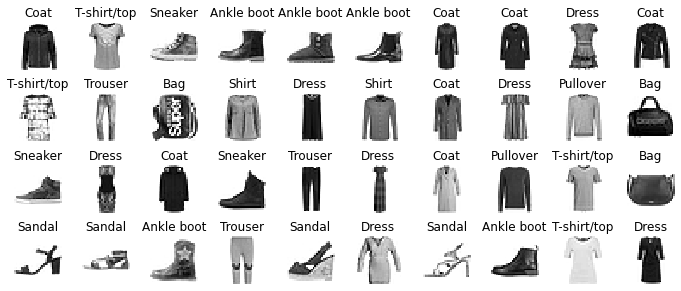

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

#Split the full training set into a validation set and a (smaller) training set. 
#We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

#convert the vector of class indices into a matrix containing a one-hot vector for each instance
num_classes = 10
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)
y_valid_onehot = tf.keras.utils.to_categorical(y_valid, num_classes)

# Sample dataset
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

def formatData_forLearning(X, Y):
  #flattens the images into 784xm dimensional data
  X = X.reshape(X.shape[0], -1).T
  Y = Y.T
  return X, Y

###################GD Softmax####################
Cost after 500 iterations: 0.5331594632540622
Cost after 1000 iterations: 0.48437113790376274
Cost after 1500 iterations: 0.46168479172075183
Cost after 2000 iterations: 0.44770937252596726
Cost after 2500 iterations: 0.4379310117296567
Cost after 3000 iterations: 0.43055993131012
Cost after 3500 iterations: 0.42472166112320986
Cost after 4000 iterations: 0.4199311931933941
Cost after 4500 iterations: 0.41589524296465863
Cost after 5000 iterations: 0.4124248182027403
Cost after 5500 iterations: 0.40939197303146385
Cost after 6000 iterations: 0.40670657809549804
Cost after 6500 iterations: 0.40430302398109036
Cost after 7000 iterations: 0.40213221326112186
Cost after 7500 iterations: 0.4001565306866593
Cost after 8000 iterations: 0.39834656947862357
Cost after 8500 iterations: 0.39667893408098404
Cost after 9000 iterations: 0.39513472515718734
Cost after 9500 iterations: 0.3936984697914036
Cost after 10000 iterations: 0.3923573498323345


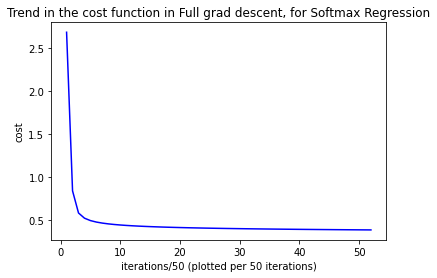

Final cost using Gradient descent: 0.3825182892011435, train set accuracy = 0.868890909090909, validation set accuracy = 0.8616


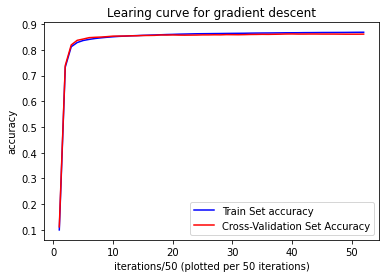

Accuracy on the test set (SGD): 0.8455
###################GD NN####################
Cost after 500 iterations: 1.9152931478593882
Cost after 1000 iterations: 1.493883870843572
Cost after 1500 iterations: 1.2379024229468352
Cost after 2000 iterations: 1.0780442660646792
Cost after 2500 iterations: 0.9693954241706251
Cost after 3000 iterations: 0.8913864184731809
Cost after 3500 iterations: 0.8332656082842984
Cost after 4000 iterations: 0.7887378180447715
Cost after 4500 iterations: 0.7537751812415704
Cost after 5000 iterations: 0.7256574317464133
Cost after 5500 iterations: 0.702500777929785
Cost after 6000 iterations: 0.6829881492458394
Cost after 6500 iterations: 0.6661949977270781
Cost after 7000 iterations: 0.6514700332741149
Cost after 7500 iterations: 0.6383519693694409
Cost after 8000 iterations: 0.6265114614841503
Cost after 8500 iterations: 0.6157110643593514
Cost after 9000 iterations: 0.6057777451223113
Cost after 9500 iterations: 0.5965837662346709
Cost after 10000 iteration

In [ ]:
def Caller2():
  X, Y = formatData_forLearning(X_train, y_train_onehot)
  #print(X.shape)
  X_val, Y_val = formatData_forLearning(X_valid, y_valid_onehot)
  #print(X_val.shape)
  X_tst, Y_tst = formatData_forLearning(X_test, y_test_onehot)
  #print(X_tst.shape)
  print("###################GD Softmax####################")
  beta_momentum = 0
  n_iter = 15000
  lr = 0.1
  lambda_reg = 1E-5
  W, b = GradDescent_softmax(X, Y, X_val, Y_val, lambda_reg, beta_momentum, n_iter, lr)
  print("Accuracy on the test set (SGD): "+str(accuracy(X_tst, Y_tst, W, b)))
  print("###################GD NN####################")
  nhidden = 100
  lr = 0.01
  weights = GradDescent_NN(X, Y, X_val, Y_val, lambda_reg, nhidden, n_iter, lr)
  print("Accuracy on the test set (SGD): "+str(accuracy_NN(X_tst, Y_tst, weights["W_1"], weights["b_1"], weights["W_2"], weights["b_2"])))

Caller2()

###################GD NN####################
Cost after 500 iterations: 0.7257080494615248
Cost after 1000 iterations: 0.5880590458333295
Cost after 1500 iterations: 0.5267318032152635
Cost after 2000 iterations: 0.49104965685928065
Cost after 2500 iterations: 0.46725736973087373
Cost after 3000 iterations: 0.4497048266562498
Cost after 3500 iterations: 0.4359683813133596
Cost after 4000 iterations: 0.42476504720324243
Cost after 4500 iterations: 0.4153268487592993


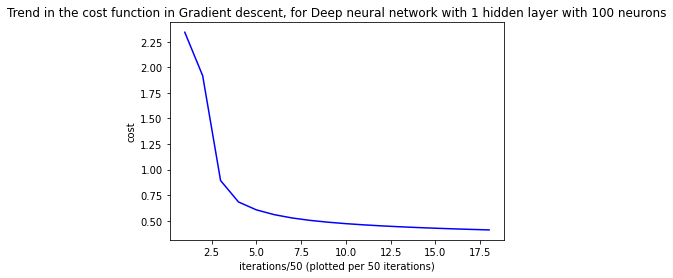

Final cost using gradient descent : 0.41055827470375655, train set accuracy = 0.8545090909090909, validation set accuracy = 0.8548


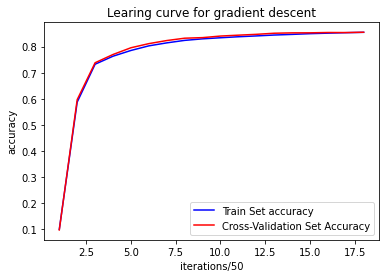

Accuracy on the test set (SGD): 0.8401


In [ ]:
def CallerNN_MNIST():
  X, Y = formatData_forLearning(X_train, y_train_onehot)
  #print(X.shape)
  X_val, Y_val = formatData_forLearning(X_valid, y_valid_onehot)
  #print(X_val.shape)
  X_tst, Y_tst = formatData_forLearning(X_test, y_test_onehot)
  n_iter = 5000
  lr = 0.1
  lambda_reg = 1E-5
  print("###################GD NN####################")
  nhidden = 100
  lr = 0.1
  weights = GradDescent_NN(X, Y, X_val, Y_val, lambda_reg, nhidden, n_iter, lr)
  print("Accuracy on the test set (SGD): "+str(accuracy_NN(X_tst, Y_tst, weights["W_1"], weights["b_1"], weights["W_2"], weights["b_2"])))

CallerNN_MNIST()

Optimal:

**Neural networks: 0.410558**

**Softmax networks: 0.382518**

#############################ALL USES DECAYING STEP SIZE################################
#########################SGD############################################
Cost after 20000 iterations: 0.5999029222381996
Cost after 40000 iterations: 0.4939352125740042
Cost after 60000 iterations: 0.45097991982353214
Cost after 80000 iterations: 0.40857183326253677
Cost after 100000 iterations: 0.3710134750946342
Cost after 120000 iterations: 0.3392605573320677
Cost after 140000 iterations: 0.31480149639268484
Cost after 160000 iterations: 0.29259849268518223
Cost after 180000 iterations: 0.2616810459495158
Cost after 200000 iterations: 0.24220217318046977
Cost after 220000 iterations: 0.22570904265596536
Cost after 240000 iterations: 0.21051806475883061
Cost after 260000 iterations: 0.20760670741010023


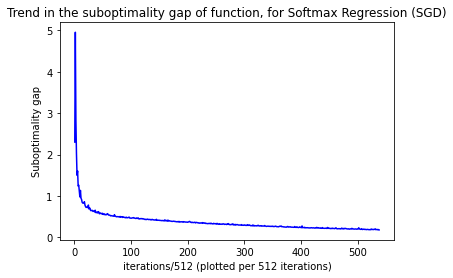

Final cost using Gradient descent: 0.18247621452384488validation set accuracy = 0.8394


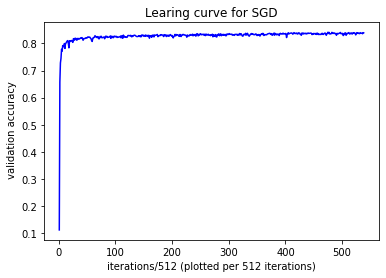

Accuracy on the test set (SGD): 0.821
#########################SVRG############################################
Cost after 40 epochs: 0.054629966918165906
Cost after 80 epochs: 0.029170878799576694
Cost after 120 epochs: 0.016956392274204757
Cost after 160 epochs: 0.00919936746772676
Cost after 200 epochs: 0.0036310520983189876
Cost after 240 epochs: -0.000656007960792071
Cost after 280 epochs: -0.004109209026369021
Cost after 320 epochs: -0.006980879782808258
Cost after 360 epochs: -0.009426101793470143
Cost after 400 epochs: -0.011546466300426161
Cost after 440 epochs: -0.013411842696639975
Cost after 480 epochs: -0.015072294256574359
Cost after 520 epochs: -0.01656471785971536


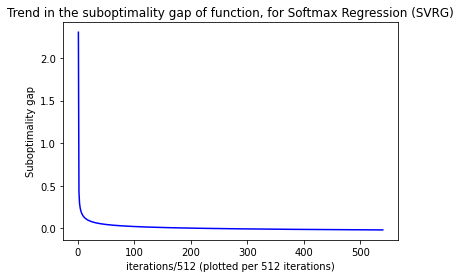

Final cost using Gradient descent: -0.017223112183895994validation set accuracy = 0.86


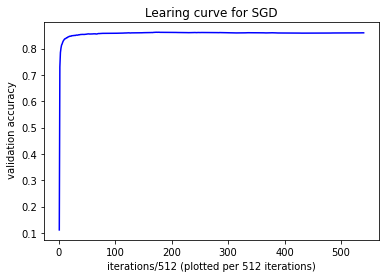

Accuracy on the test set (SVRG): 0.8461


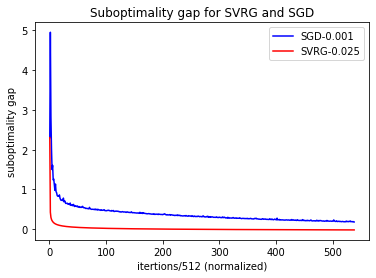

In [ ]:
def Caller_Compare_Softmax():
  X, Y = formatData_forLearning(X_train, y_train_onehot)
  #print(X.shape)
  X_val, Y_val = formatData_forLearning(X_valid, y_valid_onehot)
  #print(X_val.shape)
  X_tst, Y_tst = formatData_forLearning(X_test, y_test_onehot)
  #print(X_tst.shape)

  #convention for epochs: last argument: no_iter = n_epochs*n_examples
  print("#############################ALL USES DECAYING STEP SIZE################################")
  print("#########################SGD############################################")
  f_opt = 0.382518
  W, b, cost_diffSGD = Stochastic_GradDescent(X, Y, X_val, Y_val, 1E-5, 0, 50, 100, 5, 0.001, f_opt)
  print("Accuracy on the test set (SGD): "+str(accuracy(X_tst, Y_tst, W, b)))
  
  print("#########################SVRG############################################")
                         
  W, b, cost_diffSVRG = SVRG(X, Y, X_val, Y_val, 1E-5, 0.025, 540, 512, f_opt)
  print("Accuracy on the test set (SVRG): "+str(accuracy(X_tst, Y_tst, W, b)))

  m = min(len(cost_diffSVRG), len(cost_diffSGD))
  cost_diffSGD = cost_diffSGD[:m]
  cost_diffSVRG = cost_diffSVRG[:m]
  plot_curve2(cost_diffSGD, cost_diffSVRG, "itertions/512 (normalized)", "suboptimality gap", "Suboptimality gap for SVRG and SGD", ["SGD-0.001", "SVRG-0.025"])

Caller_Compare_Softmax()

#############################ALL USES DECAYING STEP SIZE################################
#########################SGD############################################
Cost after 20000 iterations: 0.16097576607105235
Cost after 40000 iterations: 0.12875194651113908
Cost after 60000 iterations: 0.11209760039508299
Cost after 80000 iterations: 0.1009646064427403
Cost after 100000 iterations: 0.09115545210506881
Cost after 120000 iterations: 0.07975814634132872
Cost after 140000 iterations: 0.0713151823324964
Cost after 160000 iterations: 0.06416903958343201
Cost after 180000 iterations: 0.056607098192811345
Cost after 200000 iterations: 0.05002186286399157
Cost after 220000 iterations: 0.04419324555570486
Cost after 240000 iterations: 0.040042773412509725
Cost after 260000 iterations: 0.03507823205013927


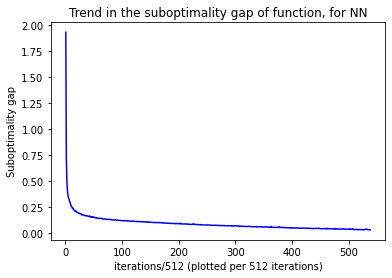

Final cost using Gradient descent: 0.030053780996862345validation set accuracy = 0.8518


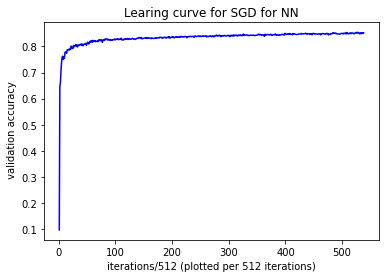

Accuracy on the test set (SGD): 0.8323
#########################SVRG############################################
Cost after 40 epochs: 0.054084093866976934
Cost after 80 epochs: -0.005296534151094323
Cost after 120 epochs: -0.03512359016074201
Cost after 160 epochs: -0.05559644493687743
Cost after 200 epochs: -0.07152733742932194
Cost after 240 epochs: -0.08484233600558821
Cost after 280 epochs: -0.09651167099115765
Cost after 320 epochs: -0.1070598108673963
Cost after 360 epochs: -0.1167514046266735
Cost after 400 epochs: -0.12574666397313272
Cost after 440 epochs: -0.1341583334987106
Cost after 480 epochs: -0.14160320757425549
Cost after 520 epochs: -0.149159700096419


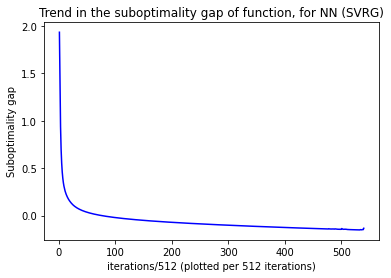

Final cost using Gradient descent: -0.13383276314444492validation set accuracy = 0.8848


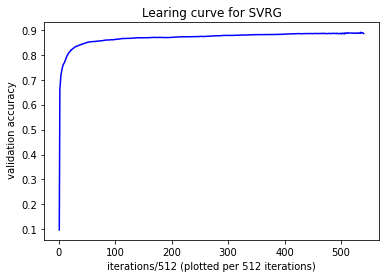

Accuracy on the test set (SGD): 0.8725


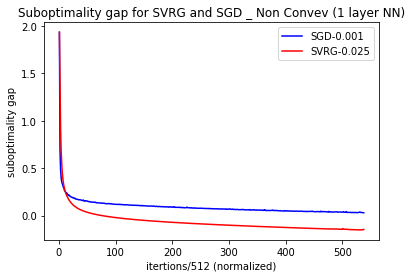

In [ ]:
def Caller_Compare_NN():
  X, Y = formatData_forLearning(X_train, y_train_onehot)
  #print(X.shape)
  X_val, Y_val = formatData_forLearning(X_valid, y_valid_onehot)
  #print(X_val.shape)
  X_tst, Y_tst = formatData_forLearning(X_test, y_test_onehot)
  #print(X_tst.shape)

  #convention for epochs: last argument: no_iter = n_epochs*n_examples
  print("#############################ALL USES DECAYING STEP SIZE################################")
  print("#########################SGD############################################")
  f_opt = 0.410558
  weights, cost_diffSGD = Stochastic_GradDescent_NN(X, Y, X_val, Y_val, 1E-5, 100, 50, 100, 5, 0.001, f_opt)
  print("Accuracy on the test set (SGD): "+str(accuracy_NN(X_tst, Y_tst, weights["W_1"], weights["b_1"], weights["W_2"], weights["b_2"])))
  
  print("#########################SVRG############################################")
                         
  weights, cost_diffSVRG = SVRG_NN(X, Y, X_val, Y_val, 1E-5, 100, 0.025, 540, 512, f_opt)
  print("Accuracy on the test set (SGD): "+str(accuracy_NN(X_tst, Y_tst, weights["W_1"], weights["b_1"], weights["W_2"], weights["b_2"])))
  
  m = min(len(cost_diffSVRG), len(cost_diffSGD))
  cost_diffSGD = cost_diffSGD[:m]
  cost_diffSVRG = cost_diffSVRG[:m]
  
  plot_curve2(cost_diffSGD, cost_diffSVRG, "itertions/512 (normalized)", "suboptimality gap", "Suboptimality gap for SVRG and SGD _ Non Convev (1 layer NN)", ["SGD-0.001", "SVRG-0.025"])

Caller_Compare_NN()

1. Condition number
2. SDCA

In [ ]:
def Caller_Compare_Softmax_SDCA_SVRG():
  X, Y = formatData_forLearning(X_train, y_train_onehot)
  #print(X.shape)
  X_val, Y_val = formatData_forLearning(X_valid, y_valid_onehot)
  #print(X_val.shape)
  X_tst, Y_tst = formatData_forLearning(X_test, y_test_onehot)
  #print(X_tst.shape)

  #convention for epochs: last argument: no_iter = n_epochs*n_examples
  print("#############################ALL USES DECAYING STEP SIZE################################")
  print("#########################SVRG############################################")
  f_opt = 0.382518
                         
  W, b, cost_diffSVRG = SVRG(X, Y, X_val, Y_val, 1E-5, 0.025, 540, 512, f_opt)
  print("Accuracy on the test set (SVRG): "+str(accuracy(X_tst, Y_tst, W, b)))
  print("#########################SDCA############################################")
  W, b, costdiffSDA = SDCA()
  print("Accuracy on the test set (SDCA): "+str(accuracy(X_tst, Y_tst, W, b)))

  m = min(len(cost_diffSVRG), len(cost_diffSDCA))

  cost_diffSVRG = cost_diffSVRG[:m]
  cost_diffSDCA = cost_diffSDCA[:m]

  plot_curve2(cost_diffSVRG, cost_diffSDCA, "itertions/512 (normalized)", "suboptimality gap", "Suboptimality gap for SVRG and SDCA ", ["SVRG-0.025", "SDCA"])

Caller_Compare_Softmax_SDCA_SVRG()

**Prof sketch**

SVRG (Stochastic Variance reduced gradients): 

In a ML problem with $n$ training examples (which can be treated as $n$ vector functions $f_i: \mathbb{R}^d \rightarrow \mathbb{R}$), we generally wish to optimize the mean loss. SVRG proposes a stochastic algorithm with **linear convergece**(in expectation) for solving this minimization problem .

The paper assumes a minimization problem as: 

$$\min F({\bf w}), \quad \text{where} \quad F({\bf w}) = \frac{1}{n}\sum\limits_{i=1}^n f_i ({\bf w})$$


**Update rule:** $\quad {\bf w}_{t+1} = {\bf w}_{t} - \eta(\nabla f_i({\bf w}_t) - \nabla f_i(\tilde{\bf w}_s) + \nabla F(\tilde{\bf w}_s)) $ 

Clearly, $\quad \mathbb{E}[{\bf w}_{t+1}|{\bf w}_{t}] = {\bf w}_{t} - \eta\nabla F({\bf w}_t)$

**Conditions on the functions:**
For $\gamma$ strongly convex $F$, and L-smooth functions $f_i$, the paper proposes the following convergence result on using a fixed step size $\eta$. The optimal solution is ${\bf w}_* ,\space \text{i.e.,} \nabla F{(\bf w}_*) = 0$.

**Main Result:** $$\mathbb{E}F(\tilde{\bf w}_s) = \mathbb{E}F({\bf w}_*) + \alpha^s (F(\tilde{\bf w}_0) - F({\bf w}_*))$$
$$\text{where} \quad \alpha = \frac{1}{\gamma \eta (1-2L\eta)}+ \frac{2L\eta}{1-2L\eta} < 1$$

**Proof:** For the sake of simplicity we see this in 3 steps:

**Step 1:** For any of the $n$ L-smooth convex functions,

Let, $ g_i({\bf w}) = f_i({\bf w}) - (f_i({\bf w}_*) + \nabla f_i^T({\bf w}_*)({\bf w} - {\bf w}_*)) \geq 0$. It represents the difference betweeen the function value at ${\bf w}$ and its Taylor approximation about ${\bf w}_*$. And $\nabla g_i({\bf w}) = \nabla f_i({\bf w}) - \nabla f_i({\bf w}_*)$.

$$\therefore \nabla^2 g_i({\bf w}) = \nabla^2 f_i({\bf w}) \leq L {\bf I}$$ 

Therfore, $g_i$ is also $L$-smooth function.

$$\therefore g_i({\bf w}') \leq g_i({\bf w}) + \nabla g_i^T({\bf w}) ({\bf w}'-{\bf w}) + \frac{\eta}{2}||{\bf w} - {\bf w}'||^2$$

$${\bf w}' = {\bf w} - \eta \nabla g_i({\bf w})$$

$$\implies 0 \leq g_i({\bf w}_*) \leq \min\limits_{\eta} g_i({\bf w} - \eta \nabla g_i({\bf w})) \leq  \min\limits_{\eta} (g_i({\bf w}) -\eta ||\nabla g_i({\bf w})||^2 + \frac{1}{2} L\eta^2 ||\nabla g_i({\bf w})||^2) = g_i({\bf w}) - \frac{1}{2L}||\nabla g_i({\bf w})||^2$$

By minimizing over $\eta$, gives $\eta = 1/L$. Taking expectation:
$$\mathbb{E}||\nabla f_i({\bf w}) - \nabla f_i({\bf w}_*)||^2 \leq 2L [F({\bf w}) - F({\bf w}_*)] \quad \quad \quad (1)$$

**Step 2:**

Finding bound for: $\mathbb{E}||{\bf w}_{t+1} - {\bf w}_*||^2$

$$= \mathbb{E}|| {\bf w}_{t} -  {\bf w}_{*} - \eta(\nabla f_i({\bf w}_t) - \nabla f_i(\tilde{\bf w}_s) + \nabla F(\tilde{\bf w}_s))||^2 $$

$$= \mathbb{E}|| {\bf w}_{t} -  {\bf w}_{*}||^2 - 2\eta({\bf w}_{t} -  {\bf w}_{*})^T\mathbb{E}[(\nabla f_i({\bf w}_t) - \nabla f_i(\tilde{\bf w}_s) + \nabla F(\tilde{\bf w}_s))]+\mathbb{E}||(\nabla f_i({\bf w}_t) - \nabla f_i(\tilde{\bf w}_s) + \nabla F(\tilde{\bf w}_s))||^2 \quad \quad \quad (2)$$

Using $||{\bf x} + {\bf y}||^2 \leq 2(||{\bf x}||^2 + ||{\bf x}||^2)$, and $\mathbb{E}||X - \mathbb{E}X||^2 \leq E||X||^2$, and result (1), we get:

$$ \mathbb{E}||(\nabla f_i({\bf w}_t) - \nabla f_i(\tilde{\bf w}_s) + \nabla F(\tilde{\bf w}_s))||^2 \leq 4L[F({\bf w}_{t}) - 2F({\bf w}_*)+F(\tilde{\bf w}_s)]$$, and $$\mathbb{E}[(\nabla f_i({\bf w}_t) - \nabla f_i(\tilde{\bf w}_s) + \nabla F(\tilde{\bf w}_s))] = F({\bf w}_t)$$

Putting these results in inequality 2, and using convexity, we get:
$$\mathbb{E}||{\bf w}_{t+1} - {\bf w}_*||^2 + 2\eta(1-2L\eta)[F({\bf w}_t)-F({\bf w}_*)]\leq \mathbb{E}|| {\bf w}_{t} -  {\bf w}_{*}||^2  + 4L\eta^2[F(\tilde{\bf w}_s)-F({\bf w}_*)] \quad \quad \quad (3)$$

**Step 3:**

Using equation 3, (taking the sum from i = 1, 2, 3, ..., m), the sum telescopes to :

$$\mathbb{E}||{\bf w}_m - {\bf w}_*||^2 + 2\eta(1-2L\eta)\sum\limits_{i=1}^m[F({\bf w}_t)-F({\bf w}_*)]\leq \mathbb{E}|| {\bf w}_{0} -  {\bf w}_{*}||^2  + 4Lm\eta^2[F(\tilde{\bf w}_s)-F({\bf w}_*)]$$

Since $\tilde{\bf w}_{s+1}=\frac{1}{m}\sum\limits_{i=1}^m{\bf w}_t$, (as at the end of the inner loop the variable is updated as follows), since $F$ is convex, by Jensens inequality, and by taking expectation on both sides (and $\tilde{\bf w}_{s} = {\bf w}_0$):  
$$ 2\eta(1-2L\eta)m\mathbb{E}[F(\tilde{\bf w}_{s+1})-F({\bf w}_*)]\leq \mathbb{E}|| \tilde{\bf w}_{s} -  {\bf w}_{*}||^2  + 4Lm\eta^2\mathbb{E}[F(\tilde{\bf w}_s)-F({\bf w}_*)]$$

As $F$ is $\gamma$ strongly convex ($|| \tilde{\bf w}_{s} -  {\bf w}_{*}||^2 \leq \frac{2}{\gamma}[F(\tilde{\bf w}_s) - F({\bf w}_*)]$):
$$\implies \mathbb{E}[F(\tilde{\bf w}_s) - F({\bf w}_*)] \leq (\frac{1}{\gamma \eta (1-2L\eta)}+ \frac{2L\eta}{1-2L\eta})\mathbb{E} (F(\tilde{\bf w}_s) - F({\bf w}_*))$$

**Hence Proved**

**Takeaways, goals and results:**

1. So the convergence rate in expectation is $O(\frac{1}{T})$, compared to $O(\frac{1}{\sqrt{T}})$ of SGD. This is because it doesn't require $\eta$ to decay by the order of 1/t as in SGD. Thus one can comparatively use a larger fixed value for $\eta$, which intuitively tells us that we converge faster.  

2. More intuitive compared to SDCA (Stochastic dual coordinate ascent). Moreover one doesn't need to store part gradients like in SAG (Stochastic average gradient) and SDCA. Reduces variance and hence gives better accuracy most of times (compared to SGD).
Variance can be seen to intuitively go to zero as (both $\tilde{\bf w}_s$ and ${\bf w}_t$ are trying to converge to $\bf w_*$, say $\tilde{\bf w}_s \rightarrow \bf w_*$):
$$\therefore \nabla f_i({\bf w}_t) - \nabla f_i({\bf w}_*) + \nabla F({\bf w}_*)  \rightarrow \nabla f_i({\bf w}_t) - \nabla f_i({\bf w}_*) \rightarrow 0$$

Thus one can intuitively see that the update goes to 0 as $\tilde{\bf w}_s$ and ${\bf w}_t$ start to converge to ${\bf w}_*$. This clearly reduces the variance of the algorithm making it converge faster and makes it attain better accuracy.

3. Can be used for convex optimization efficiently and also seen to work well for non-convex optimization like single layered neural networks. 

**If possible write about SDCA**